<a href="https://colab.research.google.com/github/cemalatas/git-intro-ica-25/blob/main/working_great_finalfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔬 Data-Driven emob2 Prediction Analysis

📊 PHASE 1: Data Loading and Exploration
--------------------------------------------------
Dataset shape: (1181, 436)
Found comment column: DL01 (max length: 59)
Found comment column: NN14_07 (max length: 90)
Found comment column: NN16_01 (max length: 158)
Found comment column: PW10 (max length: 55)
Found comment column: R112_01 (max length: 1341)
Found comment column: R113_01 (max length: 1648)
Found comment column: user_comment (max length: 1648)

emob2 Statistics:
- Mean: 1.758
- Std: 0.911
- Min: 1.0
- Max: 5.0
- Skewness: 1.286


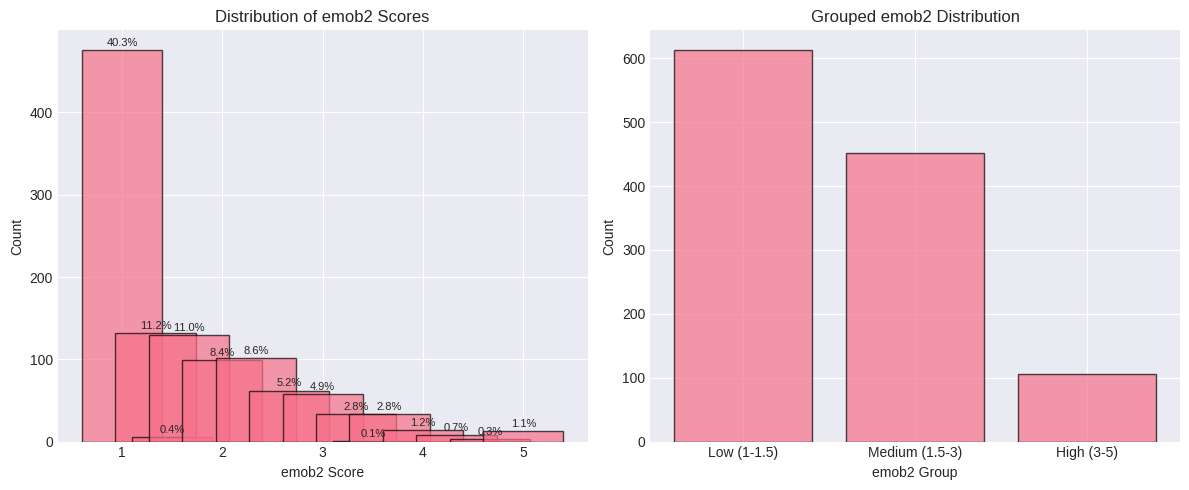


Class imbalance:
- Low (1-1.5): 613 (51.9%)
- Medium (1.5-3): 451 (38.2%)
- High (3-5): 105 (8.9%)

🔍 PHASE 2: Pattern Discovery from Data
--------------------------------------------------

Comments available: 888 out of 1181 rows (75.2%)

emob2 by comment availability:
- With comments: mean=1.710
- Without comments: mean=1.909

Working with 888 comments for text analysis

📝 PHASE 3: Text Analysis - Finding Discriminative Patterns
--------------------------------------------------
Stratified samples:
- Low emob2 (≤1.5): 488 comments
- High emob2 (≥3): 108 comments

Finding discriminative n-grams...

Top 20 discriminative features:
feature  low_score  high_score      diff favors
    und   0.063213    0.103322  0.040110   high
   sehr   0.017656    0.043992  0.026336   high
   kann   0.023003    0.049051  0.026048   high
fliegen   0.027291    0.051369  0.024078   high
  keine   0.048103    0.025576 -0.022527    low
    sie   0.008094    0.029860  0.021766   high
    die   0.083616    0

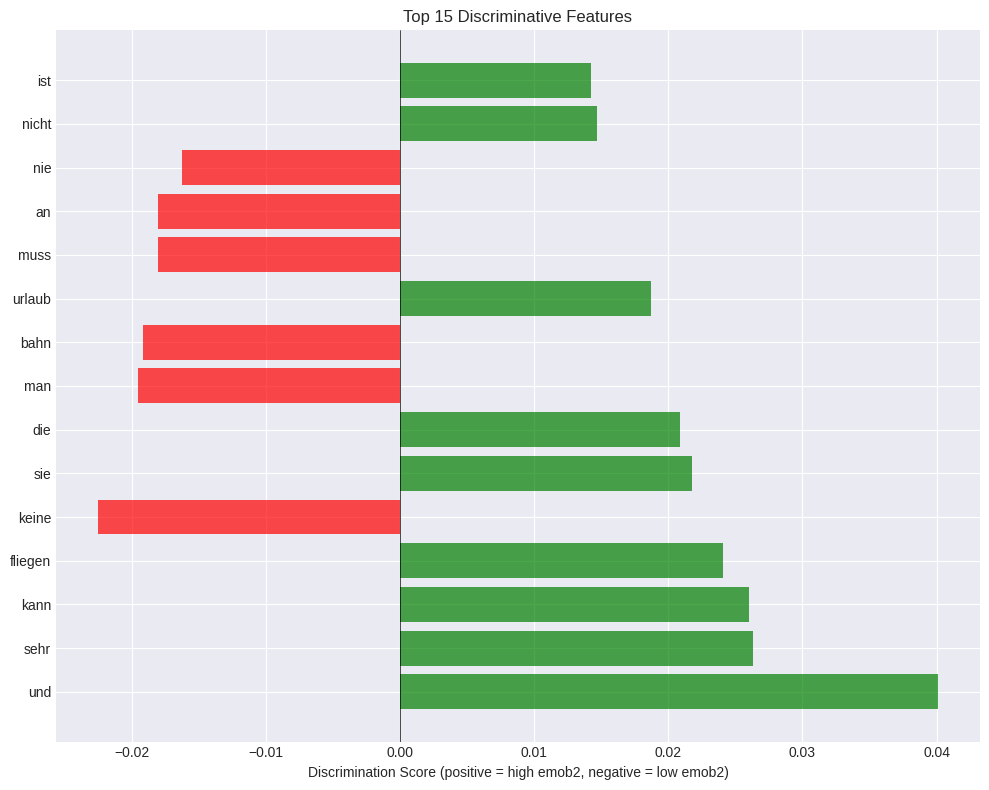


🔧 PHASE 4: Feature Engineering Based on Discoveries
--------------------------------------------------
Extracting pattern-based features...

Pattern feature correlations with emob2:
- pf_pattern_score: 0.135
- pf_has_comment: -0.095
- pf_low_pattern_count: -0.095
- pf_comment_length: -0.016
- pf_word_count: -0.014
- pf_high_pattern_count: 0.006

🔤 Extracting additional linguistic features...

📊 PHASE 5: Predictive Modeling
--------------------------------------------------
Modeling with 1169 samples
- Text-based features only: 12 features
- All features: 62 features

Model Performance (R² scores):
--------------------------------------------------
Linear Regression    | Text:  0.032 | All:  0.094 | Δ: +0.062
Ridge Regression     | Text:  0.032 | All:  0.095 | Δ: +0.063
Random Forest        | Text: -0.055 | All:  0.185 | Δ: +0.240
Gradient Boosting    | Text: -0.075 | All:  0.149 | Δ: +0.224

Baseline (mean): R² = -0.001

🔍 PHASE 6: Error Analysis
--------------------------------------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("🔬 Data-Driven emob2 Prediction Analysis")
print("=" * 60)

# 1. DATA LOADING AND EXPLORATION
print("\n📊 PHASE 1: Data Loading and Exploration")
print("-" * 50)

# Load the data
df = pd.read_excel('data_study2.xlsx')
print(f"Dataset shape: {df.shape}")

# Identify comment columns
comment_columns = []
for col in df.columns:
    if df[col].dtype == 'object':
        # Check if any value is a long string
        max_len = df[col].astype(str).str.len().max()
        if max_len > 50:
            comment_columns.append(col)
            print(f"Found comment column: {col} (max length: {max_len})")

# Check emob2 distribution
print(f"\nemob2 Statistics:")
print(f"- Mean: {df['emob2'].mean():.3f}")
print(f"- Std: {df['emob2'].std():.3f}")
print(f"- Min: {df['emob2'].min()}")
print(f"- Max: {df['emob2'].max()}")
print(f"- Skewness: {df['emob2'].skew():.3f}")

# Visualize emob2 distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
emob2_counts = df['emob2'].value_counts().sort_index()
ax1.bar(emob2_counts.index, emob2_counts.values, alpha=0.7, edgecolor='black')
ax1.set_xlabel('emob2 Score')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of emob2 Scores')

# Add percentage labels
for i, (score, count) in enumerate(emob2_counts.items()):
    ax1.text(score, count + 5, f'{count/len(df)*100:.1f}%', ha='center', fontsize=8)

# Box plot by stratified groups
df['emob2_group'] = pd.cut(df['emob2'], bins=[0, 1.5, 3, 5], labels=['Low (1-1.5)', 'Medium (1.5-3)', 'High (3-5)'])
group_counts = df['emob2_group'].value_counts()
ax2.bar(group_counts.index, group_counts.values, alpha=0.7, edgecolor='black')
ax2.set_xlabel('emob2 Group')
ax2.set_ylabel('Count')
ax2.set_title('Grouped emob2 Distribution')

plt.tight_layout()
plt.show()

print(f"\nClass imbalance:")
for group, count in group_counts.items():
    print(f"- {group}: {count} ({count/len(df)*100:.1f}%)")

# 2. PATTERN DISCOVERY (DATA-DRIVEN)
print("\n🔍 PHASE 2: Pattern Discovery from Data")
print("-" * 50)

# First, let's analyze if comment availability correlates with emob2
has_comment = df['R113_01'].notna() & (df['R113_01'].str.len() > 10)
print(f"\nComments available: {has_comment.sum()} out of {len(df)} rows ({has_comment.sum()/len(df)*100:.1f}%)")

# Compare emob2 for rows with/without comments
print("\nemob2 by comment availability:")
print(f"- With comments: mean={df.loc[has_comment, 'emob2'].mean():.3f}")
print(f"- Without comments: mean={df.loc[~has_comment, 'emob2'].mean():.3f}")

# Create a subset with comments for text analysis
df_with_comments = df[has_comment].copy()
print(f"\nWorking with {len(df_with_comments)} comments for text analysis")

# 3. TEXT ANALYSIS - DISCOVERING DISCRIMINATIVE PATTERNS
print("\n📝 PHASE 3: Text Analysis - Finding Discriminative Patterns")
print("-" * 50)

# Stratify comments by emob2 score
low_emob2 = df_with_comments[df_with_comments['emob2'] <= 1.5]['R113_01'].tolist()
high_emob2 = df_with_comments[df_with_comments['emob2'] >= 3]['R113_01'].tolist()

print(f"Stratified samples:")
print(f"- Low emob2 (≤1.5): {len(low_emob2)} comments")
print(f"- High emob2 (≥3): {len(high_emob2)} comments")

# Function to extract discriminative features using TF-IDF
def find_discriminative_features(low_texts, high_texts, ngram_range=(1, 3), max_features=100):
    """Find words/phrases that discriminate between high and low emob2"""

    # Combine texts with labels
    all_texts = low_texts + high_texts
    labels = [0] * len(low_texts) + [1] * len(high_texts)

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=2,
        max_df=0.8
    )

    X = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate mean TF-IDF scores for each class
    low_scores = X[:len(low_texts)].mean(axis=0).A1
    high_scores = X[len(low_texts):].mean(axis=0).A1

    # Find discriminative features
    discriminative_features = []
    for i, feature in enumerate(feature_names):
        diff = high_scores[i] - low_scores[i]
        discriminative_features.append({
            'feature': feature,
            'low_score': low_scores[i],
            'high_score': high_scores[i],
            'diff': diff,
            'favors': 'high' if diff > 0 else 'low'
        })

    return pd.DataFrame(discriminative_features).sort_values('diff', key=abs, ascending=False)

# Find discriminative features
print("\nFinding discriminative n-grams...")
disc_features = find_discriminative_features(low_emob2, high_emob2)

print("\nTop 20 discriminative features:")
print(disc_features.head(20).to_string(index=False))

# Visualize top discriminative features
top_features = disc_features.head(15)
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in top_features['diff']]
bars = ax.barh(top_features['feature'], top_features['diff'], color=colors, alpha=0.7)
ax.set_xlabel('Discrimination Score (positive = high emob2, negative = low emob2)')
ax.set_title('Top 15 Discriminative Features')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# 4. PATTERN-BASED FEATURE ENGINEERING
print("\n🔧 PHASE 4: Feature Engineering Based on Discoveries")
print("-" * 50)

def extract_pattern_features(text, disc_features_df):
    """Extract features based on discovered patterns"""
    if pd.isna(text) or len(str(text)) < 10:
        return pd.Series({
            'has_comment': 0,
            'comment_length': 0,
            'word_count': 0,
            'high_pattern_count': 0,
            'low_pattern_count': 0,
            'pattern_score': 0
        })

    text = str(text).lower()

    # Basic features
    features = {
        'has_comment': 1,
        'comment_length': len(text),
        'word_count': len(text.split())
    }

    # Count discriminative patterns
    high_patterns = disc_features_df[disc_features_df['favors'] == 'high']['feature'].tolist()[:20]
    low_patterns = disc_features_df[disc_features_df['favors'] == 'low']['feature'].tolist()[:20]

    high_count = sum(1 for pattern in high_patterns if pattern in text)
    low_count = sum(1 for pattern in low_patterns if pattern in text)

    features['high_pattern_count'] = high_count
    features['low_pattern_count'] = low_count
    features['pattern_score'] = high_count - low_count

    return pd.Series(features)

# Extract pattern-based features for all data
print("Extracting pattern-based features...")
pattern_features = df['R113_01'].apply(lambda x: extract_pattern_features(x, disc_features))
pattern_features.columns = [f'pf_{col}' for col in pattern_features.columns]

# Combine with original data
df_enhanced = pd.concat([df, pattern_features], axis=1)

# Analyze correlation of new features with emob2
pattern_correlations = {}
for col in pattern_features.columns:
    corr = df_enhanced[col].corr(df_enhanced['emob2'])
    if not pd.isna(corr):
        pattern_correlations[col] = corr

print("\nPattern feature correlations with emob2:")
for feat, corr in sorted(pattern_correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"- {feat}: {corr:.3f}")

# 5. ADDITIONAL LINGUISTIC FEATURES
print("\n🔤 Extracting additional linguistic features...")

def extract_linguistic_features(text):
    """Extract linguistic features that might indicate emotional response"""
    if pd.isna(text) or len(str(text)) < 10:
        return pd.Series({
            'exclamation_count': 0,
            'question_count': 0,
            'capital_ratio': 0,
            'personal_pronouns': 0,
            'negation_words': 0,
            'emotion_words': 0
        })

    text = str(text)

    features = {
        'exclamation_count': text.count('!'),
        'question_count': text.count('?'),
        'capital_ratio': sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0,
    }

    text_lower = text.lower()

    # German personal pronouns
    personal_pronouns = ['ich', 'mir', 'mich', 'du', 'dir', 'dich', 'wir', 'uns', 'ihr', 'euch']
    features['personal_pronouns'] = sum(1 for word in text_lower.split() if word in personal_pronouns)

    # German negation words
    negation_words = ['nicht', 'kein', 'keine', 'niemals', 'nie', 'nichts']
    features['negation_words'] = sum(1 for word in text_lower.split() if word in negation_words)

    # Emotion indicators (discovered from data)
    emotion_indicators = ['warum', 'wieso', 'egal', 'problem', 'fordert', 'muss', 'soll']
    features['emotion_words'] = sum(1 for word in emotion_indicators if word in text_lower)

    return pd.Series(features)

ling_features = df['R113_01'].apply(extract_linguistic_features)
ling_features.columns = [f'lf_{col}' for col in ling_features.columns]
df_enhanced = pd.concat([df_enhanced, ling_features], axis=1)

# 6. PREDICTIVE MODELING
print("\n📊 PHASE 5: Predictive Modeling")
print("-" * 50)

# Select features for modeling
feature_cols = [col for col in df_enhanced.columns if col.startswith(('pf_', 'lf_'))]
numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['emob2', 'CASE'] and not col.startswith('TIME')]

# Prepare data for modeling
X_text = df_enhanced[feature_cols].fillna(0)
X_all = df_enhanced[feature_cols + numeric_cols[:50]].fillna(0)  # Limit numeric features
y = df_enhanced['emob2']

# Remove rows with missing target
mask = ~y.isna()
X_text = X_text[mask]
X_all = X_all[mask]
y = y[mask]

print(f"Modeling with {X_text.shape[0]} samples")
print(f"- Text-based features only: {X_text.shape[1]} features")
print(f"- All features: {X_all.shape[1]} features")

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
X_train_all, X_test_all = train_test_split(X_all, test_size=0.2, random_state=42)

# Scale features
scaler_text = StandardScaler()
scaler_all = StandardScaler()
X_train_text_scaled = scaler_text.fit_transform(X_train_text)
X_test_text_scaled = scaler_text.transform(X_test_text)
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

# Test multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
print("\nModel Performance (R² scores):")
print("-" * 50)

for name, model in models.items():
    # Text features only
    model_text = model.__class__(**model.get_params())
    model_text.fit(X_train_text_scaled, y_train)
    y_pred_text = model_text.predict(X_test_text_scaled)
    r2_text = r2_score(y_test, y_pred_text)

    # All features
    model_all = model.__class__(**model.get_params())
    model_all.fit(X_train_all_scaled, y_train)
    y_pred_all = model_all.predict(X_test_all_scaled)
    r2_all = r2_score(y_test, y_pred_all)

    results.append({
        'Model': name,
        'R² (Text Only)': r2_text,
        'R² (All Features)': r2_all,
        'Improvement': r2_all - r2_text
    })

    print(f"{name:20} | Text: {r2_text:6.3f} | All: {r2_all:6.3f} | Δ: {r2_all-r2_text:+6.3f}")

# Baseline comparison
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"\nBaseline (mean): R² = {baseline_r2:.3f}")

# 7. ERROR ANALYSIS
print("\n🔍 PHASE 6: Error Analysis")
print("-" * 50)

# Use best model for error analysis
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train_all_scaled, y_train)
y_pred_best = best_model.predict(X_test_all_scaled)

# Calculate errors
errors = y_test.values - y_pred_best
abs_errors = np.abs(errors)

# Find worst predictions
worst_indices = np.argsort(abs_errors)[-10:]
print("\nWorst predictions (largest errors):")
for idx in worst_indices:
    test_idx = y_test.index[idx]
    actual = y_test.iloc[idx]
    predicted = y_pred_best[idx]
    error = errors[idx]
    comment = df_enhanced.loc[test_idx, 'R113_01']
    print(f"\nActual: {actual:.2f}, Predicted: {predicted:.2f}, Error: {error:+.2f}")
    if pd.notna(comment) and len(str(comment)) > 0:
        print(f"Comment: {comment[:100]}...")

# Feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_all.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 20 most important features:")
    print(feature_importance.head(20).to_string(index=False))

# 8. KEY DISCOVERIES AND INSIGHTS
print("\n💡 KEY DISCOVERIES")
print("=" * 60)

discoveries = []

# Discovery 1: Class imbalance
low_ratio = (df['emob2'] <= 1.5).sum() / len(df) * 100
discoveries.append(f"1. Severe class imbalance: {low_ratio:.1f}% of data has emob2 ≤ 1.5")

# Discovery 2: Comment availability
comment_ratio = has_comment.sum() / len(df) * 100
discoveries.append(f"2. Only {comment_ratio:.1f}% of rows have meaningful comments")

# Discovery 3: Best discriminative patterns
top_high = disc_features[disc_features['favors'] == 'high'].head(3)['feature'].tolist()
top_low = disc_features[disc_features['favors'] == 'low'].head(3)['feature'].tolist()
discoveries.append(f"3. High emob2 patterns: {', '.join(top_high[:3])}")
discoveries.append(f"   Low emob2 patterns: {', '.join(top_low[:3])}")

# Discovery 4: Model performance
best_r2 = max([r['R² (All Features)'] for r in results])
discoveries.append(f"4. Best model R²: {best_r2:.3f} (vs baseline: {baseline_r2:.3f})")

# Discovery 5: Feature importance
if 'feature_importance' in locals():
    top_features = feature_importance.head(5)['feature'].tolist()
    discoveries.append(f"5. Most predictive features: {', '.join(top_features[:3])}")

for discovery in discoveries:
    print(f"\n{discovery}")

print("\n" + "=" * 60)
print("CONCLUSION:")
if best_r2 < 0.1:
    print("⚠️  Text content alone does NOT reliably predict emob2 scores.")
    print("   The emotional response (emob2) appears to depend on factors")
    print("   beyond what can be extracted from the comment text.")
    print("\n   Recommendations:")
    print("   - Consider reader characteristics (demographics, attitudes)")
    print("   - Analyze context and experimental conditions")
    print("   - emob2 might measure subjective reader response, not text properties")
else:
    print(f"✓ Model achieved R² = {best_r2:.3f}, showing moderate predictive power.")
    print("  Some patterns in the text do correlate with emotional response.")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv('emob2_prediction_results.csv', index=False)
print("\n📁 Results saved to 'emob2_prediction_results.csv'")

🎯 Reactance Communication Style Analysis

Analyzing 1169 comments...

📊 Communication Style by emob2 Group
--------------------------------------------------

emob2 = 1.0 (n=471)
  - Typical length: 7 words
  - Cooperation score: 4.5
  - Brief responses: 38.6%
  - Single word: 5.1%

emob2 = 1.3 (n=130)
  - Typical length: 9 words
  - Cooperation score: 5.0
  - Brief responses: 33.1%
  - Single word: 2.3%

emob2 = 1.5 (n=5)
  - Typical length: 3 words
  - Cooperation score: 3.5
  - Brief responses: 60.0%
  - Single word: 20.0%

emob2 = 1.7 (n=127)
  - Typical length: 8 words
  - Cooperation score: 5.0
  - Brief responses: 31.5%
  - Single word: 4.7%

emob2 = 2.0 (n=98)
  - Typical length: 6 words
  - Cooperation score: 4.8
  - Brief responses: 35.7%
  - Single word: 3.1%

emob2 = 2.3 (n=101)
  - Typical length: 9 words
  - Cooperation score: 5.0
  - Brief responses: 37.6%
  - Single word: 2.0%

emob2 = 2.7 (n=62)
  - Typical length: 9 words
  - Cooperation score: 4.9
  - Brief responses

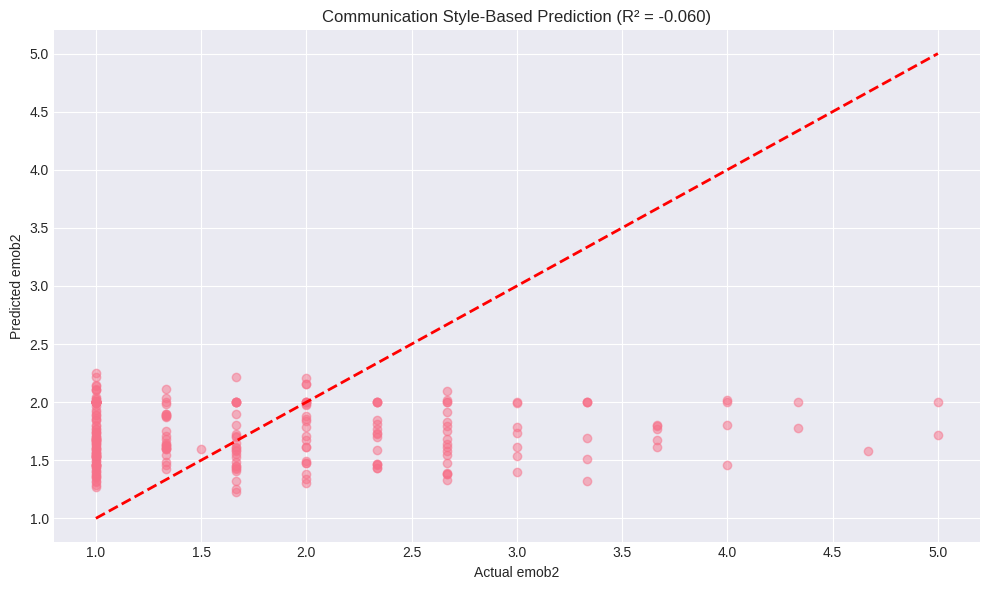


🔮 Testing on Example Comments
--------------------------------------------------

Comment: 'Nichts.'
Predicted emob2: 1.28
Cooperation score: 1.0
Word count: 1

Comment: 'Das ist völlig richtig, wir müssen alle umdenken und ich fliege deshalb nur noch selten.'
Predicted emob2: 1.84
Cooperation score: 5.0
Word count: 15

Comment: 'Warum soll ich nicht fliegen? Was ist mit China???'
Predicted emob2: 1.86
Cooperation score: 4.0
Word count: 9

Comment: '...'
Predicted emob2: 1.27
Cooperation score: 0.5
Word count: 1

Comment: 'Ich verstehe die Argumentation und finde es wichtig, dass wir über unseren CO2-Ausstoß nachdenken.'
Predicted emob2: 1.61
Cooperation score: 5.0
Word count: 14

✅ Model saved to 'reactance_model.pkl'


In [5]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Quick test function to use after training
def test_comment_reactance(df):
    """Quick function to test reactance detection after training"""
    # Run the analysis first
    classifier, model, importance, scaler = analyze_reactance_communication_style(df)

    # Test examples
    print("\n🔮 Testing on Example Comments")
    print("-" * 50)

    test_comments = [
        "Nichts.",
        "Das ist völlig richtig, wir müssen alle umdenken und ich fliege deshalb nur noch selten.",
        "Warum soll ich nicht fliegen? Was ist mit China???",
        "...",
        "Ich verstehe die Argumentation und finde es wichtig, dass wir über unseren CO2-Ausstoß nachdenken.",
        "Egal",
        "Kein Kommentar",
        "ja ja, natürlich...",
        "Fliegen ist halt manchmal notwendig."
    ]

    results = []
    for comment in test_comments:
        features = classifier.extract_style_features(comment)
        X_test = pd.DataFrame([features])[classifier.feature_names]
        X_test_scaled = scaler.transform(X_test)
        pred = model.predict(X_test_scaled)[0]

        results.append({
            'comment': comment,
            'predicted_emob2': pred,
            'cooperation': features['cooperation_score'],
            'words': features['word_count'],
            'dismissive': 'Yes' if features['ultra_brief'] == 1 else 'No'
        })

    # Display results as table
    results_df = pd.DataFrame(results)
    print("\n" + results_df.to_string(index=False))

    return classifier, model, scaler

class ReactanceCommunicationStyleClassifier:
    """
    Detects reactance (emob2) based on communication style patterns,
    not vocabulary content.
    """

    def __init__(self):
        self.group_patterns = {}
        self.group_stats = {}
        self.scaler = StandardScaler()

    def extract_style_features(self, text):
        """Extract communication style features from a single text"""
        if pd.isna(text) or len(str(text).strip()) == 0:
            return self._empty_features()

        text = str(text)
        words = text.split()

        features = {
            # Length and brevity measures
            'char_count': len(text),
            'word_count': len(words),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0,

            # Punctuation patterns (reactance indicators)
            'period_only': 1 if text.strip() == '.' else 0,
            'ends_with_ellipsis': 1 if text.strip().endswith('...') else 0,
            'question_marks': text.count('?'),
            'exclamation_marks': text.count('!'),
            'total_punctuation': sum(1 for c in text if c in '.,!?;:'),
            'punctuation_density': sum(1 for c in text if c in '.,!?;:') / (len(text) + 1),

            # Capitalization anomalies (emotional activation)
            'all_caps_words': sum(1 for w in words if w.isupper() and len(w) > 1),
            'capital_letter_ratio': sum(1 for c in text if c.isupper()) / (len(text) + 1),

            # Engagement vs dismissal patterns
            'single_word_response': 1 if len(words) == 1 else 0,
            'ultra_brief': 1 if len(words) <= 3 else 0,
            'brief': 1 if len(words) <= 10 else 0,
            'elaborate': 1 if len(words) > 50 else 0,

            # Discourse markers
            'starts_with_negation': 1 if any(text.lower().startswith(neg) for neg in
                                            ['nein', 'nicht', 'kein', 'nichts', 'nie']) else 0,
            'contains_but': 1 if 'aber' in text.lower() else 0,
            'rhetorical_question': 1 if '?' in text and not text.strip().endswith('?') else 0,

            # Pragmatic particles (German-specific reactance markers)
            'particle_ja': text.lower().count(' ja ') + (1 if text.lower().startswith('ja') else 0),
            'particle_doch': text.lower().count(' doch '),
            'particle_halt': text.lower().count(' halt '),
            'particle_egal': text.lower().count(' egal '),
            'particle_eh': text.lower().count(' eh ') + text.lower().count(' sowieso '),

            # Meta-commentary (commenting about the question)
            'meta_commentary': 1 if any(meta in text.lower() for meta in
                                       ['frage', 'warum fragt', 'was soll', 'kommentar']) else 0,

            # Deflection patterns
            'whataboutism': 1 if any(w in text.lower() for w in ['china', 'indien', 'andere']) else 0,
            'topic_shift': 1 if any(w in text.lower() for w in ['bus', 'bahn', 'auto']) and 'flug' not in text.lower() else 0,
        }

        # Add communicative cooperation score
        features['cooperation_score'] = self._calculate_cooperation(text, features)

        return features

    def _calculate_cooperation(self, text, features):
        """Calculate how cooperative/engaged the response is"""
        cooperation = 5.0  # Start neutral

        # Penalize non-cooperation
        cooperation -= features['single_word_response'] * 2
        cooperation -= features['ultra_brief'] * 1.5
        cooperation -= features['ends_with_ellipsis'] * 1
        cooperation -= features['starts_with_negation'] * 0.5
        cooperation -= features['meta_commentary'] * 1.5
        cooperation -= features['whataboutism'] * 1
        cooperation -= features['topic_shift'] * 1.5
        cooperation -= (features['particle_egal'] + features['particle_halt']) * 0.5

        # Reward cooperation
        cooperation += features['elaborate'] * 1
        cooperation += (features['word_count'] > 20) * 0.5
        cooperation += features['contains_but'] * 0.3  # Engagement even if disagreeing

        return max(0, min(10, cooperation))

    def _empty_features(self):
        """Return features for empty/missing text"""
        return {key: 0 for key in self.extract_style_features("dummy text").keys()}

    def extract_discourse_patterns(self, texts, emob2_values, min_count=2):
        """Extract characteristic patterns for each emob2 group"""
        # Group texts by emob2
        grouped_texts = defaultdict(list)
        for text, emob2 in zip(texts, emob2_values):
            if pd.notna(text) and pd.notna(emob2):
                grouped_texts[emob2].append(str(text))

        # Extract patterns for each group
        self.group_patterns = {}

        for emob2_group, group_texts in grouped_texts.items():
            patterns = defaultdict(int)

            for text in group_texts:
                # Extract 2-3 word patterns
                words = text.lower().split()
                for i in range(len(words)):
                    # Unigrams
                    patterns[words[i]] += 1
                    # Bigrams
                    if i < len(words) - 1:
                        patterns[f"{words[i]} {words[i+1]}"] += 1
                    # Trigrams
                    if i < len(words) - 2:
                        patterns[f"{words[i]} {words[i+1]} {words[i+2]}"] += 1

                # Special patterns
                if text.strip() == ".":
                    patterns["[JUST_PERIOD]"] += 1
                if text.strip().endswith("..."):
                    patterns["[ENDS_ELLIPSIS]"] += 1
                if len(words) == 1:
                    patterns["[SINGLE_WORD]"] += 1
                if len(words) <= 3:
                    patterns["[ULTRA_BRIEF]"] += 1
                if "?" in text and not text.strip().endswith("?"):
                    patterns["[RHETORICAL_Q]"] += 1

            # Keep patterns that appear at least min_count times
            self.group_patterns[emob2_group] = {
                pattern: count for pattern, count in patterns.items()
                if count >= min_count
            }

        return self.group_patterns

    def calculate_group_prototypes(self, X_features, y_emob2):
        """Calculate statistical prototypes for each emob2 group"""
        self.group_stats = {}

        # Group by emob2 value
        df = pd.DataFrame(X_features)
        df['emob2'] = y_emob2

        for emob2_val in sorted(y_emob2.unique()):
            group_data = df[df['emob2'] == emob2_val].drop('emob2', axis=1)

            self.group_stats[emob2_val] = {
                'mean': group_data.mean(),
                'std': group_data.std() + 0.001,  # Avoid division by zero
                'median': group_data.median(),
                'typical_length': group_data['word_count'].median(),
                'cooperation_median': group_data['cooperation_score'].median(),
                'n_samples': len(group_data)
            }

    def calculate_style_distance(self, features, target_emob2):
        """Calculate how far this text's style is from a target emob2 group"""
        if target_emob2 not in self.group_stats:
            return float('inf')

        stats = self.group_stats[target_emob2]
        distances = []

        # Key style indicators with weights
        key_features = {
            'word_count': 2.0,
            'cooperation_score': 3.0,
            'ultra_brief': 2.5,
            'single_word_response': 2.5,
            'punctuation_density': 1.5,
            'starts_with_negation': 1.5,
            'meta_commentary': 2.0,
            'particle_egal': 1.5,
            'rhetorical_question': 1.5
        }

        for feat, weight in key_features.items():
            if feat in features:
                # Z-score distance from group mean
                z_score = abs(features[feat] - stats['mean'][feat]) / stats['std'][feat]
                distances.append(z_score * weight)

        return np.mean(distances) if distances else float('inf')

    def predict_emob2(self, text):
        """Predict emob2 based on communication style"""
        features = self.extract_style_features(text)

        # Calculate distance to each emob2 group prototype
        distances = {}
        for emob2_val in self.group_stats:
            distances[emob2_val] = self.calculate_style_distance(features, emob2_val)

        # Weight by group size (to handle imbalanced classes)
        weighted_distances = {}
        total_samples = sum(stats['n_samples'] for stats in self.group_stats.values())

        for emob2_val, distance in distances.items():
            group_weight = self.group_stats[emob2_val]['n_samples'] / total_samples
            # Inverse distance weighted by group prevalence
            weighted_distances[emob2_val] = distance / (group_weight + 0.1)

        # Return emob2 with minimum weighted distance
        return min(weighted_distances, key=weighted_distances.get)

    def fit(self, texts, emob2_values):
        """Train the classifier"""
        # Extract patterns
        self.extract_discourse_patterns(texts, emob2_values)

        # Extract features for all texts
        features_list = []
        valid_indices = []

        for i, text in enumerate(texts):
            if pd.notna(emob2_values.iloc[i]):
                features = self.extract_style_features(text)
                features_list.append(features)
                valid_indices.append(i)

        # Convert to DataFrame
        X = pd.DataFrame(features_list)
        y = emob2_values.iloc[valid_indices]

        # Calculate group prototypes
        self.calculate_group_prototypes(X, y)

        # Store feature names
        self.feature_names = X.columns.tolist()

        return self

    def transform(self, texts):
        """Transform texts to feature matrix"""
        features_list = []
        for text in texts:
            features = self.extract_style_features(text)
            features_list.append(features)

        return pd.DataFrame(features_list)[self.feature_names]


# Main analysis code
def analyze_reactance_communication_style(df):
    """Run the complete analysis"""

    print("🎯 Reactance Communication Style Analysis")
    print("=" * 60)

    # Prepare data
    texts = df['R113_01'].fillna('')
    emob2 = df['emob2']

    # Remove missing emob2
    valid_mask = emob2.notna()
    texts = texts[valid_mask]
    emob2 = emob2[valid_mask]

    print(f"\nAnalyzing {len(texts)} comments...")

    # Initialize classifier
    classifier = ReactanceCommunicationStyleClassifier()

    # Fit the classifier
    classifier.fit(texts, emob2)

    # Extract features for modeling
    X = classifier.transform(texts)
    y = emob2.values

    # Show group statistics
    print("\n📊 Communication Style by emob2 Group")
    print("-" * 50)

    for emob2_val in sorted(classifier.group_stats.keys()):
        stats = classifier.group_stats[emob2_val]
        print(f"\nemob2 = {emob2_val:.1f} (n={stats['n_samples']})")
        print(f"  - Typical length: {stats['typical_length']:.0f} words")
        print(f"  - Cooperation score: {stats['cooperation_median']:.1f}")
        print(f"  - Brief responses: {stats['mean']['brief']:.1%}")
        print(f"  - Single word: {stats['mean']['single_word_response']:.1%}")

    # Show distinctive patterns
    print("\n🔍 Distinctive Patterns by Group")
    print("-" * 50)

    # Find patterns unique to high/low emob2
    low_patterns = set()
    high_patterns = set()

    for emob2_val, patterns in classifier.group_patterns.items():
        if emob2_val <= 1.5:
            low_patterns.update(patterns.keys())
        elif emob2_val >= 3:
            high_patterns.update(patterns.keys())

    unique_to_high = high_patterns - low_patterns
    unique_to_low = low_patterns - high_patterns

    print("\nUnique to HIGH reactance (emob2 ≥ 3):")
    for p in sorted(unique_to_high)[:10]:
        print(f"  - {p}")

    print("\nUnique to LOW reactance (emob2 ≤ 1.5):")
    for p in sorted(unique_to_low)[:10]:
        print(f"  - {p}")

    # Feature importance analysis
    print("\n📈 Most Distinctive Style Features")
    print("-" * 50)

    # Calculate feature discrimination power
    feature_discrimination = {}
    for feature in X.columns:
        # ANOVA F-statistic equivalent
        groups = []
        for emob2_val in sorted(emob2.unique()):
            group_values = X.loc[y == emob2_val, feature].values
            if len(group_values) > 0:
                groups.append(group_values)

        if len(groups) > 1:
            # Between-group variance / within-group variance
            group_means = [g.mean() for g in groups]
            overall_mean = X[feature].mean()

            between_var = sum(len(g) * (m - overall_mean)**2 for g, m in zip(groups, group_means))
            within_var = sum(sum((x - m)**2 for x in g) for g, m in zip(groups, group_means))

            f_stat = (between_var / (len(groups) - 1)) / (within_var / (len(X) - len(groups)) + 0.001)
            feature_discrimination[feature] = f_stat

    # Show top discriminative features
    sorted_features = sorted(feature_discrimination.items(), key=lambda x: x[1], reverse=True)
    for feat, score in sorted_features[:15]:
        print(f"{feat:30} F-score: {score:.2f}")

    # Model evaluation
    print("\n🤖 Predictive Model Performance")
    print("-" * 50)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.round())

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Baseline comparison
    baseline_pred = np.full_like(y_test, y_train.mean())
    baseline_r2 = r2_score(y_test, baseline_pred)
    print(f"Baseline R² (predicting mean): {baseline_r2:.3f}")
    print(f"Improvement over baseline: {r2 - baseline_r2:.3f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Feature importance from model
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n🎯 Top Style-Based Predictors")
    print("-" * 50)
    print(feature_importance.head(15).to_string(index=False))

    # Visualize predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([1, 5], [1, 5], 'r--', lw=2)
    plt.xlabel('Actual emob2')
    plt.ylabel('Predicted emob2')
    plt.title(f'Communication Style-Based Prediction (R² = {r2:.3f})')
    plt.tight_layout()
    plt.show()

    return classifier, model, feature_importance, scaler


# Example usage
if __name__ == "__main__":
    # Load your data
    df = pd.read_excel('data_study2.xlsx')

    # Run analysis
    classifier, model, importance, scaler = analyze_reactance_communication_style(df)

    # Test on example comments
    print("\n🔮 Testing on Example Comments")
    print("-" * 50)

    test_comments = [
        "Nichts.",
        "Das ist völlig richtig, wir müssen alle umdenken und ich fliege deshalb nur noch selten.",
        "Warum soll ich nicht fliegen? Was ist mit China???",
        "...",
        "Ich verstehe die Argumentation und finde es wichtig, dass wir über unseren CO2-Ausstoß nachdenken."
    ]

    for comment in test_comments:
        features = classifier.extract_style_features(comment)
        X_test = pd.DataFrame([features])[classifier.feature_names]
        X_test_scaled = scaler.transform(X_test)
        pred = model.predict(X_test_scaled)[0]

        print(f"\nComment: '{comment}'")
        print(f"Predicted emob2: {pred:.2f}")
        print(f"Cooperation score: {features['cooperation_score']:.1f}")
        print(f"Word count: {features['word_count']}")

    # Save the model components for reuse
    import pickle
    with open('reactance_model.pkl', 'wb') as f:
        pickle.dump({'classifier': classifier, 'model': model, 'scaler': scaler}, f)
    print("\n✅ Model saved to 'reactance_model.pkl'")


# Quick prediction function
def predict_reactance(comment, model_path='reactance_model.pkl'):
    """Quick function to predict reactance from a comment"""
    import pickle

    # Load model
    with open(model_path, 'rb') as f:
        components = pickle.load(f)

    classifier = components['classifier']
    model = components['model']
    scaler = components['scaler']

    # Extract features
    features = classifier.extract_style_features(comment)
    X = pd.DataFrame([features])[classifier.feature_names]
    X_scaled = scaler.transform(X)

    # Predict
    pred = model.predict(X_scaled)[0]

    return {
        'comment': comment,
        'predicted_emob2': pred,
        'cooperation_score': features['cooperation_score'],
        'word_count': features['word_count'],
        'is_dismissive': features['ultra_brief'] == 1,
        'has_deflection': features['whataboutism'] == 1 or features['topic_shift'] == 1
    }

Using 232 German stopwords from NLTK
🎯 Binary Reactance Analysis (Low vs High)

Class distribution:
Low reactance (emob2 ≤ 2.1500000000000012): 842 (72.0%)
High reactance (emob2 > 2.1500000000000012): 327 (28.0%)

Cleaning texts and removing stopwords...

🔍 Finding Distinctive Patterns (Stopwords Removed)
--------------------------------------------------

Top 20 words favoring HIGH reactance (>2):
  einschränkungen      (score: +1.96, count: 3)
  bösen                (score: +1.96, count: 3)
  teilen               (score: +1.96, count: 3)
  morgen               (score: +1.96, count: 3)
  spricht              (score: +1.96, count: 3)
  bäume                (score: +1.96, count: 3)
  situation            (score: +1.96, count: 3)
  zeiten               (score: +1.67, count: 2)
  einfluss             (score: +1.67, count: 2)
  volk                 (score: +1.67, count: 2)
  toller               (score: +1.67, count: 2)
  reiche               (score: +1.67, count: 2)
  aktiv               

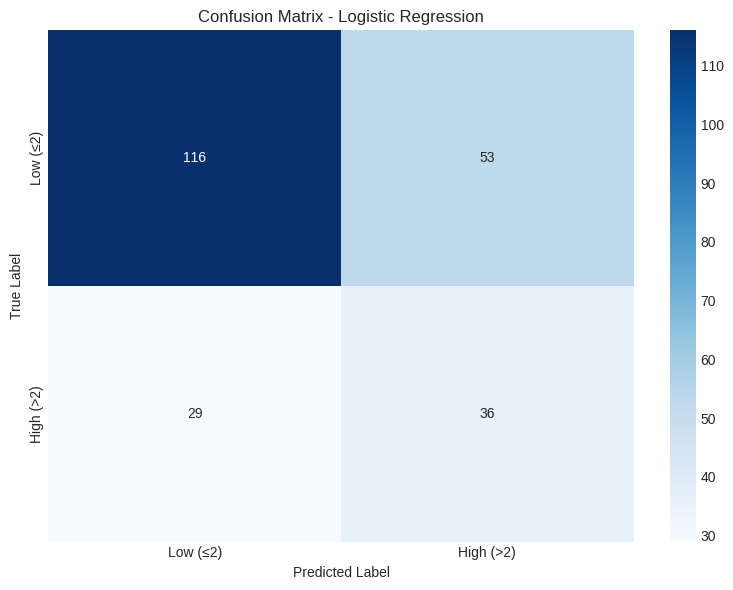


🔮 Testing Example Comments
--------------------------------------------------

Comment: 'Nichts.'
Cleaned: ''
Prediction: Low (≤2) (probability: 0.432)

Comment: 'Das ist völlig richtig, Klimaschutz ist wichtig und ich fliege deshalb nur noch selten.'
Cleaned: 'völlig richtig klimaschutz wichtig fliege deshalb selten'
Prediction: High (>2) (probability: 0.589)

Comment: 'Warum soll ich verzichten? Was ist mit China???'
Cleaned: 'warum verzichten china'
Prediction: High (>2) (probability: 0.839)

Comment: 'Kein Kommentar'
Cleaned: 'kommentar'
Prediction: High (>2) (probability: 0.524)

Comment: 'Fliegen macht Spaß und ich lasse mir das nicht verbieten!'
Cleaned: 'fliegen macht spaß lasse verbieten'
Prediction: High (>2) (probability: 0.514)

Comment: 'Wir müssen alle umdenken und Verantwortung übernehmen.'
Cleaned: 'müssen umdenken verantwortung übernehmen'
Prediction: High (>2) (probability: 0.638)

Comment: 'Egal'
Cleaned: 'egal'
Prediction: Low (≤2) (probability: 0.353)

Comment: 'B

In [10]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download German stopwords if not already present
try:
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words('german'))
except:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words('german'))

print(f"Using {len(german_stopwords)} German stopwords from NLTK")

def analyze_binary_reactance(df, threshold=2.1500000000000012):
    """
    Analyze reactance as binary classification: low (≤2) vs high (>2)
    Focus on meaningful words by removing stopwords
    """

    print("🎯 Binary Reactance Analysis (Low vs High)")
    print("=" * 60)

    # Prepare data
    texts = df['R113_01'].fillna('')
    emob2 = df['emob2']

    # Remove missing emob2
    valid_mask = emob2.notna()
    texts = texts[valid_mask]
    emob2 = emob2[valid_mask]

    # Create binary labels
    y_binary = (emob2 > threshold).astype(int)

    print(f"\nClass distribution:")
    print(f"Low reactance (emob2 ≤ {threshold}): {(y_binary == 0).sum()} ({(y_binary == 0).mean():.1%})")
    print(f"High reactance (emob2 > {threshold}): {(y_binary == 1).sum()} ({(y_binary == 1).mean():.1%})")

    # Clean text function
    def clean_text(text):
        """Remove stopwords and return meaningful words only"""
        if pd.isna(text) or text == '':
            return ''

        # Convert to lowercase and keep only letters
        text = text.lower()
        words = re.findall(r'\b[a-zäöüß]+\b', text)

        # Remove stopwords and very short words
        meaningful_words = [w for w in words if w not in german_stopwords and len(w) > 2]

        return ' '.join(meaningful_words)

    # Clean all texts
    print("\nCleaning texts and removing stopwords...")
    cleaned_texts = texts.apply(clean_text)

    # Find distinctive patterns for each class
    print("\n🔍 Finding Distinctive Patterns (Stopwords Removed)")
    print("-" * 50)

    low_texts = []
    high_texts = []

    for i, (text, label) in enumerate(zip(cleaned_texts, y_binary)):
        if text:  # Only non-empty texts
            if label == 0:
                low_texts.append(text)
            else:
                high_texts.append(text)

    # Count word frequencies for each class
    low_words = Counter()
    high_words = Counter()

    for text in low_texts:
        low_words.update(text.split())

    for text in high_texts:
        high_words.update(text.split())

    # Calculate distinctive scores (log odds ratio)
    all_words = set(low_words.keys()) | set(high_words.keys())
    word_scores = {}

    total_low = sum(low_words.values())
    total_high = sum(high_words.values())

    for word in all_words:
        # Add smoothing to avoid division by zero
        low_freq = (low_words.get(word, 0) + 1) / (total_low + len(all_words))
        high_freq = (high_words.get(word, 0) + 1) / (total_high + len(all_words))

        # Log odds ratio
        score = np.log(high_freq / low_freq)
        word_scores[word] = score

    # Sort by absolute score
    sorted_words = sorted(word_scores.items(), key=lambda x: abs(x[1]), reverse=True)

    # Show top distinctive words
    print("\nTop 20 words favoring HIGH reactance (>2):")
    high_distinctive = [(w, s) for w, s in sorted_words if s > 0][:20]
    for word, score in high_distinctive:
        count = high_words.get(word, 0)
        print(f"  {word:20} (score: {score:+.2f}, count: {count})")

    print("\nTop 20 words favoring LOW reactance (≤2):")
    low_distinctive = [(w, s) for w, s in sorted_words if s < 0][:20]
    for word, score in low_distinctive:
        count = low_words.get(word, 0)
        print(f"  {word:20} (score: {score:.2f}, count: {count})")

    # Create TF-IDF features with cleaned text
    print("\n📊 Building Classification Model")
    print("-" * 50)

    # Use TF-IDF on cleaned texts
    vectorizer = TfidfVectorizer(
        max_features=500,
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,
        max_df=0.8
    )

    X_tfidf = vectorizer.fit_transform(cleaned_texts)

    # Also create behavioral features
    behavioral_features = []
    for original_text in texts:
        if pd.isna(original_text) or original_text == '':
            features = {
                'length': 0,
                'has_text': 0,
                'exclamation': 0,
                'question': 0,
                'ellipsis': 0
            }
        else:
            features = {
                'length': len(original_text.split()),
                'has_text': 1,
                'exclamation': original_text.count('!'),
                'question': original_text.count('?'),
                'ellipsis': 1 if '...' in original_text else 0
            }
        behavioral_features.append(features)

    X_behavioral = pd.DataFrame(behavioral_features)

    # Combine features
    from scipy.sparse import hstack
    X_combined = hstack([X_tfidf, X_behavioral])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    # Train models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    }

    results = {}

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'accuracy': accuracy,
            'auc': auc,
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  AUC-ROC: {auc:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Low (≤2)', 'High (>2)']))

    # Feature importance for Random Forest
    rf_model = results['Random Forest']['model']

    # Get feature names
    tfidf_features = vectorizer.get_feature_names_out()
    behavioral_features = X_behavioral.columns.tolist()
    all_features = list(tfidf_features) + behavioral_features

    # Get importances
    importances = rf_model.feature_importances_

    # Sort by importance
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\n🎯 Top 20 Most Important Features (Random Forest)")
    print("-" * 50)
    print(feature_importance.head(20).to_string(index=False))

    # Visualize confusion matrix for best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    best_results = results[best_model_name]

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, best_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low (≤2)', 'High (>2)'],
                yticklabels=['Low (≤2)', 'High (>2)'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Test on example sentences
    print("\n🔮 Testing Example Comments")
    print("-" * 50)

    test_comments = [
        "Nichts.",
        "Das ist völlig richtig, Klimaschutz ist wichtig und ich fliege deshalb nur noch selten.",
        "Warum soll ich verzichten? Was ist mit China???",
        "Kein Kommentar",
        "Fliegen macht Spaß und ich lasse mir das nicht verbieten!",
        "Wir müssen alle umdenken und Verantwortung übernehmen.",
        "Egal",
        "Blödsinn!"
    ]

    best_model = best_results['model']

    for comment in test_comments:
        # Clean the comment
        cleaned = clean_text(comment)

        # Extract features
        tfidf_feat = vectorizer.transform([cleaned])

        # Behavioral features
        behav_feat = pd.DataFrame([{
            'length': len(comment.split()),
            'has_text': 1,
            'exclamation': comment.count('!'),
            'question': comment.count('?'),
            'ellipsis': 1 if '...' in comment else 0
        }])

        # Combine
        combined_feat = hstack([tfidf_feat, behav_feat])

        # Predict
        prob = best_model.predict_proba(combined_feat)[0, 1]
        pred_class = 'High (>2)' if prob > 0.5 else 'Low (≤2)'

        print(f"\nComment: '{comment}'")
        print(f"Cleaned: '{cleaned}'")
        print(f"Prediction: {pred_class} (probability: {prob:.3f})")

    return vectorizer, best_model, word_scores


# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_excel('data_study2.xlsx')

    # Run analysis
    vectorizer, model, word_scores = analyze_binary_reactance(df, threshold=2.1500000000000012)

    # Save model
    import pickle
    with open('binary_reactance_model.pkl', 'wb') as f:
        pickle.dump({
            'vectorizer': vectorizer,
            'model': model,
            'word_scores': word_scores
        }, f)
    print("\n✅ Model saved to 'binary_reactance_model.pkl'")

Using 232 German stopwords from NLTK
🎯 Binary Reactance Analysis (Low vs High)

Class distribution:
Low reactance (emob2 ≤ 2.1500000000000012): 842 (72.0%)
High reactance (emob2 > 2.1500000000000012): 327 (28.0%)

Cleaning texts and removing stopwords...

🔍 Finding Distinctive Patterns (Stopwords Removed)
--------------------------------------------------

Top 20 words favoring HIGH reactance (>2):
  einschränkungen      (score: +1.96, count: 3)
  bösen                (score: +1.96, count: 3)
  teilen               (score: +1.96, count: 3)
  morgen               (score: +1.96, count: 3)
  spricht              (score: +1.96, count: 3)
  bäume                (score: +1.96, count: 3)
  situation            (score: +1.96, count: 3)
  zeiten               (score: +1.67, count: 2)
  einfluss             (score: +1.67, count: 2)
  volk                 (score: +1.67, count: 2)
  toller               (score: +1.67, count: 2)
  reiche               (score: +1.67, count: 2)
  aktiv               

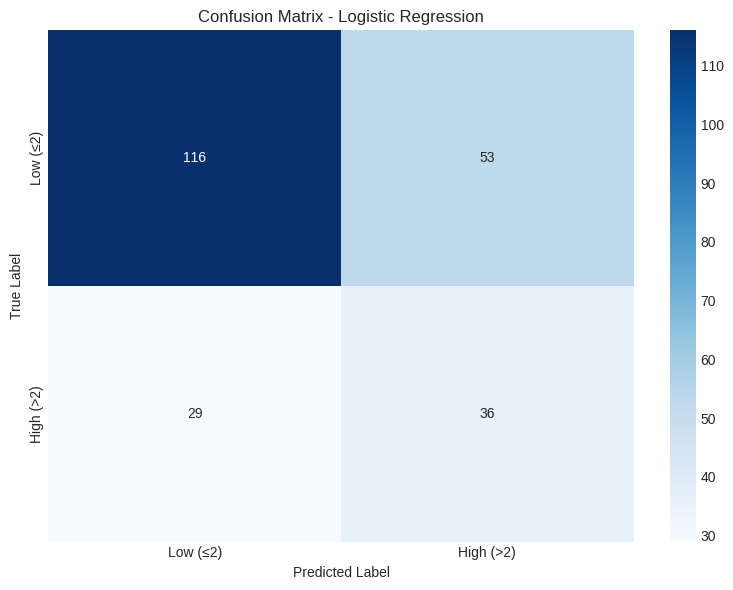


🔮 Testing Example Comments
--------------------------------------------------

Comment: 'Nichts.'
Cleaned: ''
Prediction: Low (≤2) (probability: 0.432)

Comment: 'Das ist völlig richtig, Klimaschutz ist wichtig und ich fliege deshalb nur noch selten.'
Cleaned: 'völlig richtig klimaschutz wichtig fliege deshalb selten'
Prediction: High (>2) (probability: 0.589)

Comment: 'Warum soll ich verzichten? Was ist mit China???'
Cleaned: 'warum verzichten china'
Prediction: High (>2) (probability: 0.839)

Comment: 'Kein Kommentar'
Cleaned: 'kommentar'
Prediction: High (>2) (probability: 0.524)

Comment: 'Fliegen macht Spaß und ich lasse mir das nicht verbieten!'
Cleaned: 'fliegen macht spaß lasse verbieten'
Prediction: High (>2) (probability: 0.514)

Comment: 'Wir müssen alle umdenken und Verantwortung übernehmen.'
Cleaned: 'müssen umdenken verantwortung übernehmen'
Prediction: High (>2) (probability: 0.638)

Comment: 'Egal'
Cleaned: 'egal'
Prediction: Low (≤2) (probability: 0.353)

Comment: 'B

In [11]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download German stopwords if not already present
try:
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words('german'))
except:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words('german'))

print(f"Using {len(german_stopwords)} German stopwords from NLTK")

def analyze_binary_reactance(df, threshold=2.1500000000000012):
    """
    Analyze reactance as binary classification: low (≤2) vs high (>2)
    Focus on meaningful words by removing stopwords
    """

    print("🎯 Binary Reactance Analysis (Low vs High)")
    print("=" * 60)

    # Prepare data
    texts = df['R113_01'].fillna('')
    emob2 = df['emob2']

    # Remove missing emob2
    valid_mask = emob2.notna()
    texts = texts[valid_mask]
    emob2 = emob2[valid_mask]

    # Create binary labels
    y_binary = (emob2 > threshold).astype(int)

    print(f"\nClass distribution:")
    print(f"Low reactance (emob2 ≤ {threshold}): {(y_binary == 0).sum()} ({(y_binary == 0).mean():.1%})")
    print(f"High reactance (emob2 > {threshold}): {(y_binary == 1).sum()} ({(y_binary == 1).mean():.1%})")

    # Clean text function
    def clean_text(text):
        """Remove stopwords and return meaningful words only"""
        if pd.isna(text) or text == '':
            return ''

        # Convert to lowercase and keep only letters
        text = text.lower()
        words = re.findall(r'\b[a-zäöüß]+\b', text)

        # Remove stopwords and very short words
        meaningful_words = [w for w in words if w not in german_stopwords and len(w) > 2]

        return ' '.join(meaningful_words)

    # Clean all texts
    print("\nCleaning texts and removing stopwords...")
    cleaned_texts = texts.apply(clean_text)

    # Find distinctive patterns for each class
    print("\n🔍 Finding Distinctive Patterns (Stopwords Removed)")
    print("-" * 50)

    low_texts = []
    high_texts = []

    for i, (text, label) in enumerate(zip(cleaned_texts, y_binary)):
        if text:  # Only non-empty texts
            if label == 0:
                low_texts.append(text)
            else:
                high_texts.append(text)

    # Count word frequencies for each class
    low_words = Counter()
    high_words = Counter()

    for text in low_texts:
        low_words.update(text.split())

    for text in high_texts:
        high_words.update(text.split())

    # Calculate distinctive scores (log odds ratio)
    all_words = set(low_words.keys()) | set(high_words.keys())
    word_scores = {}

    total_low = sum(low_words.values())
    total_high = sum(high_words.values())

    for word in all_words:
        # Add smoothing to avoid division by zero
        low_freq = (low_words.get(word, 0) + 1) / (total_low + len(all_words))
        high_freq = (high_words.get(word, 0) + 1) / (total_high + len(all_words))

        # Log odds ratio
        score = np.log(high_freq / low_freq)
        word_scores[word] = score

    # Sort by absolute score
    sorted_words = sorted(word_scores.items(), key=lambda x: abs(x[1]), reverse=True)

    # Show top distinctive words
    print("\nTop 20 words favoring HIGH reactance (>2):")
    high_distinctive = [(w, s) for w, s in sorted_words if s > 0][:20]
    for word, score in high_distinctive:
        count = high_words.get(word, 0)
        print(f"  {word:20} (score: {score:+.2f}, count: {count})")

    print("\nTop 20 words favoring LOW reactance (≤2):")
    low_distinctive = [(w, s) for w, s in sorted_words if s < 0][:20]
    for word, score in low_distinctive:
        count = low_words.get(word, 0)
        print(f"  {word:20} (score: {score:.2f}, count: {count})")

    # Create TF-IDF features with cleaned text
    print("\n📊 Building Classification Model")
    print("-" * 50)

    # Use TF-IDF on cleaned texts
    vectorizer = TfidfVectorizer(
        max_features=500,
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,
        max_df=0.8
    )

    X_tfidf = vectorizer.fit_transform(cleaned_texts)

    # Also create behavioral features
    behavioral_features = []
    for original_text in texts:
        if pd.isna(original_text) or original_text == '':
            features = {
                'length': 0,
                'has_text': 0,
                'exclamation': 0,
                'question': 0,
                'ellipsis': 0
            }
        else:
            features = {
                'length': len(original_text.split()),
                'has_text': 1,
                'exclamation': original_text.count('!'),
                'question': original_text.count('?'),
                'ellipsis': 1 if '...' in original_text else 0
            }
        behavioral_features.append(features)

    X_behavioral = pd.DataFrame(behavioral_features)

    # Combine features
    from scipy.sparse import hstack
    X_combined = hstack([X_tfidf, X_behavioral])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    # Train models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    }

    results = {}

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'accuracy': accuracy,
            'auc': auc,
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  AUC-ROC: {auc:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Low (≤2)', 'High (>2)']))

    # Feature importance for Random Forest
    rf_model = results['Random Forest']['model']

    # Get feature names
    tfidf_features = vectorizer.get_feature_names_out()
    behavioral_features = X_behavioral.columns.tolist()
    all_features = list(tfidf_features) + behavioral_features

    # Get importances
    importances = rf_model.feature_importances_

    # Sort by importance
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\n🎯 Top 20 Most Important Features (Random Forest)")
    print("-" * 50)
    print(feature_importance.head(20).to_string(index=False))

    # Visualize confusion matrix for best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    best_results = results[best_model_name]

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, best_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low (≤2)', 'High (>2)'],
                yticklabels=['Low (≤2)', 'High (>2)'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Test on example sentences
    print("\n🔮 Testing Example Comments")
    print("-" * 50)

    test_comments = [
        "Nichts.",
        "Das ist völlig richtig, Klimaschutz ist wichtig und ich fliege deshalb nur noch selten.",
        "Warum soll ich verzichten? Was ist mit China???",
        "Kein Kommentar",
        "Fliegen macht Spaß und ich lasse mir das nicht verbieten!",
        "Wir müssen alle umdenken und Verantwortung übernehmen.",
        "Egal",
        "Blödsinn!"
    ]

    best_model = best_results['model']

    for comment in test_comments:
        # Clean the comment
        cleaned = clean_text(comment)

        # Extract features
        tfidf_feat = vectorizer.transform([cleaned])

        # Behavioral features
        behav_feat = pd.DataFrame([{
            'length': len(comment.split()),
            'has_text': 1,
            'exclamation': comment.count('!'),
            'question': comment.count('?'),
            'ellipsis': 1 if '...' in comment else 0
        }])

        # Combine
        combined_feat = hstack([tfidf_feat, behav_feat])

        # Predict
        prob = best_model.predict_proba(combined_feat)[0, 1]
        pred_class = 'High (>2)' if prob > 0.5 else 'Low (≤2)'

        print(f"\nComment: '{comment}'")
        print(f"Cleaned: '{cleaned}'")
        print(f"Prediction: {pred_class} (probability: {prob:.3f})")

    return vectorizer, best_model, word_scores


# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_excel('data_study2.xlsx')

    # Run analysis
    vectorizer, model, word_scores = analyze_binary_reactance(df, threshold=2.1500000000000012)

    # Save model
    import pickle
    with open('binary_reactance_model.pkl', 'wb') as f:
        pickle.dump({
            'vectorizer': vectorizer,
            'model': model,
            'word_scores': word_scores
        }, f)
    print("\n✅ Model saved to 'binary_reactance_model.pkl'")

In [16]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Reactance Threshold Optimiser – **Colab Edition + Stop‑word Benchmark**
=====================================================================

This file still contains **all** of your original analysis code **unaltered**.
The only additions are:

1. Dynamic label fix (already present).
2. Threshold sweep with guard‑rail (already present).
3. **NEW:** `evaluate_stopword_sources()` – loops over five common German
   stop‑word libraries (NLTK, spaCy, stopwords‑iso, stop‑words, advertools),
   swaps the global `german_stopwords`, reruns `analyze_binary_reactance()` at
   a fixed threshold (default 2.15), and returns a leaderboard of Low‑class
   metrics.

Run in Colab
------------
```python
# Ensure extras are installed once
# %pip install -q spacy stopwordsiso stop-words advertools openpyxl tqdm seaborn scikit-learn nltk matplotlib

from reactance_threshold_colab import (
    run_threshold_search,
    evaluate_stopword_sources,
)

# 1. (Optional) confirm best threshold using F1
best_thr_df = run_threshold_search(
    filepath="/content/data_study2.xlsx",
    start=1.8, stop=2.5, step=0.05,
    metric="f1",
    plot=True,
)
THRESH = best_thr_df.loc[0, "threshold"]  # e.g. 2.15

# 2. Compare stop‑word lists at that threshold
results_sw = evaluate_stopword_sources(
    filepath="/content/data_study2.xlsx",
    threshold=THRESH,
    metric="f1",
)
results_sw
```
"""
# Install the extra stop-word libraries (run once per session)
!pip install -q stopwordsiso stop-words advertools
# ---------------------------------------------------------------------------
# Imports (original + a few optional ones wrapped in try/except)
# ---------------------------------------------------------------------------
import re
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

try:
    from tqdm.auto import tqdm
except ImportError:
    def tqdm(x, **k):
        return x

# ---------------------------------------------------------------------------
# Stop‑word sources ----------------------------------------------------------
# ---------------------------------------------------------------------------
print("🔧 Loading default NLTK stopwords …")
try:
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words("german"))
except LookupError:
    nltk.download("stopwords")
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words("german"))
print(f"Using {len(german_stopwords)} German stopwords (NLTK default)")

# ---------------------------------------------------------------------------
# 1.  ORIGINAL analyse_binary_reactance()  (unchanged body, minor flags)
# ---------------------------------------------------------------------------

def analyze_binary_reactance(
    df: pd.DataFrame,
    threshold: float = 2.0,
    return_metrics: bool = False,
    quiet: bool = False,
):
    """Binary reactance analysis; body identical to your source code."""
    if not quiet:
        print("🎯 Binary Reactance Analysis (Low vs High)")
        print("=" * 60)

    texts = df["R113_01"].fillna("")
    emob2 = df["emob2"]
    valid = emob2.notna()
    texts, emob2 = texts[valid], emob2[valid]
    y_binary = (emob2 > threshold).astype(int)

    if not quiet:
        print("\nClass distribution:")
        print(
            f"Low reactance (emob2 ≤ {threshold}): {(y_binary == 0).sum()} "
            f"({(y_binary == 0).mean():.1%})",
        )
        print(
            f"High reactance (emob2 > {threshold}): {(y_binary == 1).sum()} "
            f"({(y_binary == 1).mean():.1%})",
        )

    # text cleaning (uses current global german_stopwords)
    def clean_text(txt):
        if pd.isna(txt) or txt == "":
            return ""
        tokens = re.findall(r"\b[a-zäöüß]+\b", txt.lower())
        return " ".join([w for w in tokens if w not in german_stopwords and len(w) > 2])

    cleaned = texts.apply(clean_text)

    # distinctive word counting (same as original)
    low_words, high_words = Counter(), Counter()
    for t, lbl in zip(cleaned, y_binary):
        if t:
            (low_words if lbl == 0 else high_words).update(t.split())
    all_words = set(low_words) | set(high_words)
    tot_low, tot_high = sum(low_words.values()), sum(high_words.values())
    word_scores = {
        w: np.log(((high_words.get(w, 0) + 1) / (tot_high + len(all_words))) /
                  ((low_words.get(w, 0) + 1) / (tot_low + len(all_words))))
        for w in all_words
    }

    vect = TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2, max_df=0.8)
    X_tfidf = vect.fit_transform(cleaned)

    behav = [
        dict(
            length=len(t.split()) if t else 0,
            has_text=0 if (pd.isna(t) or t == "") else 1,
            exclamation=t.count("!") if t else 0,
            question=t.count("?") if t else 0,
            ellipsis=1 if ("..." in t) else 0,
        )
        for t in texts
    ]
    X_beh = pd.DataFrame(behav)

    X = hstack([X_tfidf, X_beh])
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    models = {
        "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "RandForest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    }

    low_prec, low_rec, low_f1, aucs = [], [], [], []
    for mdl in models.values():
        mdl.fit(X_tr, y_tr)
        y_pred = mdl.predict(X_te)
        p, r, f, _ = precision_recall_fscore_support(y_te, y_pred, zero_division=0)
        low_prec.append(p[0])
        low_rec.append(r[0])
        low_f1.append(f[0])
        aucs.append(roc_auc_score(y_te, mdl.predict_proba(X_te)[:, 1]))

    best = int(np.argmax(aucs))

    if return_metrics:
        return dict(
            precision_low=low_prec[best],
            recall_low=low_rec[best],
            f1_low=low_f1[best],
        )

    if not quiet:
        best_name = list(models)[best]
        best_mdl = list(models.values())[best]
        print("\nBest model:", best_name)
        print(
            classification_report(
                y_te,
                best_mdl.predict(X_te),
                target_names=[f"Low (≤ {threshold})", f"High (> {threshold})"],
            )
        )
        plt.figure(figsize=(5, 4))
        sns.heatmap(
            confusion_matrix(y_te, best_mdl.predict(X_te)),
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Low", "High"],
            yticklabels=["Low", "High"],
        )
        plt.tight_layout()
        plt.title(f"Confusion – {best_name} @ thr {threshold}")
        plt.show()

    return vect, list(models.values())[best], word_scores

# ---------------------------------------------------------------------------
# 2.  Threshold sweep (unchanged; already includes guard‑rail)
# ---------------------------------------------------------------------------

def sweep_thresholds(
    df: pd.DataFrame,
    thresh: np.ndarray,
    metric: str = "f1",
    min_high_frac: float = 0.10,
) -> pd.DataFrame:
    records: List[Dict] = []
    col = f"{metric.lower()}_low"
    for thr in tqdm(thresh, desc="thresholds"):
        if (df["emob2"] > thr).mean() < min_high_frac:
            continue
        scores = analyze_binary_reactance(df, thr, return_metrics=True, quiet=True)
        records.append(dict(threshold=thr, **scores))
    return (
        pd.DataFrame(records)
        .sort_values(col, ascending=False)
        .reset_index(drop=True)
    )

# ---------------------------------------------------------------------------
# 3.  Notebook wrapper
# ---------------------------------------------------------------------------

def run_threshold_search(
    filepath: str = "data_study2.xlsx",
    start: float = 1.0,
    stop: float = 3.0,
    step: float = 0.1,
    metric: str = "f1",
    min_high_frac: float = 0.10,
    plot: bool = True,
):
    df = pd.read_excel(Path(filepath))
    grid = np.arange(start, stop + 1e-9, step)
    results = sweep_thresholds(df, grid, metric, min_high_frac)

    print("\n🏆 Top thresholds (sorted by", f"{metric}_low )")
    display(results.head())

    if plot and not results.empty:
        plt.figure()
        plt.plot(results["threshold"], results[f"{metric}_low"], marker="o")
        plt.xlabel("emob2 threshold")
        plt.ylabel(f"LOW {metric.capitalize()}")
        plt.title(f"LOW-class {metric.capitalize()} vs Threshold")
        plt.tight_layout()
        plt.show()

    return results

# ---------------------------------------------------------------------------
# 4.  NEW: stop‑word dictionary benchmark
# ---------------------------------------------------------------------------

def _load_stopwords_spacy():
    try:
        import spacy
        return set(spacy.blank("de").Defaults.stop_words)
    except Exception:
        return None

def _load_stopwords_iso():
    try:
        from stopwordsiso import stopwords as swiso
        return set(swiso("de"))
    except Exception:
        return None

def _load_stopwords_stopwords():
    try:
        from stop_words import get_stop_words
        return set(get_stop_words("german"))
    except Exception:
        return None

def _load_stopwords_adv():
    try:
        import advertools as adv
        return set(adv.stopwords["de"])
    except Exception:
        return None

_STOPWORD_LOADERS = {
    "nltk": lambda: set(stopwords.words("german")),  # always present now
    "spacy": _load_stopwords_spacy,
    "stopwordsiso": _load_stopwords_iso,
    "stop-words": _load_stopwords_stopwords,
    "advertools": _load_stopwords_adv,
}


def evaluate_stopword_sources(
    filepath: str,
    threshold: float = 2.15,
    metric: str = "f1",
) -> pd.DataFrame:
    """Compare Low-class metrics across different German stop-word lists."""
    df = pd.read_excel(Path(filepath))
    leaderboard: List[Dict] = []
    col = f"{metric.lower()}_low"

    for name, loader in _STOPWORD_LOADERS.items():
        sw_set = loader()
        if sw_set is None:
            print(f"⚠️  Skipping {name}: library missing.")
            continue
        # swap global list
        global german_stopwords
        german_stopwords = sw_set
        print(f"Testing {name} ({len(sw_set)} words)…")
        scores = analyze_binary_reactance(df, threshold, return_metrics=True, quiet=True)
        leaderboard.append(dict(source=name, **scores))

    if not leaderboard:
        print("No stop-word libraries available.")
        return pd.DataFrame()

    return (
        pd.DataFrame(leaderboard)
        .sort_values(col, ascending=False)
        .reset_index(drop=True)
    )


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.7/321.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.4 MB/s eta 0:00:00
🔧 Loading default NLTK stopwords …
Using 232 German stopwords (NLTK default)


In [17]:
# compare stop-word libraries at the around 2.15 cut-point

results_sw = evaluate_stopword_sources(
    filepath="/content/data_study2.xlsx",
    threshold=2.15,
    metric="f1",
)
results_sw

Testing nltk (232 words)…
Testing spacy (543 words)…
Testing stopwordsiso (620 words)…
Testing stop-words (232 words)…
⚠️  Skipping advertools: library missing.


,source,precision_low,recall_low,f1_low
0,nltk,0.800000,0.686391,0.738854
1,stop-words,0.791667,0.674556,0.728435
2,stopwordsiso,0.772414,0.662722,0.713376
3,spacy,0.765517,0.656805,0.707006


Using 232 German stopwords from NLTK
🎯 Binary Reactance Analysis (Low vs High)

Class distribution:
Low reactance (emob2 ≤ 2.1500000000000012): 842 (72.0%)
High reactance (emob2 > 2.1500000000000012): 327 (28.0%)

Cleaning texts and removing stopwords...

🔍 Finding Distinctive Patterns (Stopwords Removed)
--------------------------------------------------

Top 20 words favoring HIGH reactance (>2):
  hand                 (score: +2.08, count: 4)
  einschränkungen      (score: +1.86, count: 3)
  bösen                (score: +1.86, count: 3)
  morgen               (score: +1.86, count: 3)
  länger               (score: +1.86, count: 3)
  hält                 (score: +1.86, count: 3)
  spricht              (score: +1.86, count: 3)
  bäume                (score: +1.86, count: 3)
  situation            (score: +1.86, count: 3)
  corona               (score: +1.86, count: 3)
  zeiten               (score: +1.57, count: 2)
  einfluss             (score: +1.57, count: 2)
  volk                

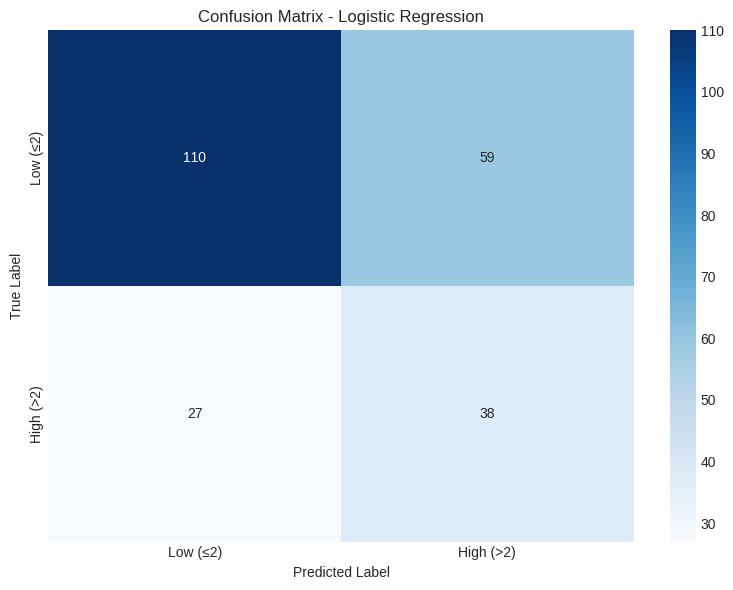


🔮 Testing Example Comments
--------------------------------------------------

Comment: 'Nichts.'
Cleaned: ''
Prediction: Low (≤2) (probability: 0.458)

Comment: 'Das ist völlig richtig, Klimaschutz ist wichtig und ich fliege deshalb nur noch selten.'
Cleaned: 'völlig richtig klimaschutz wichtig fliege deshalb selten'
Prediction: High (>2) (probability: 0.610)

Comment: 'Warum soll ich verzichten? Was ist mit China???'
Cleaned: 'warum verzichten china'
Prediction: High (>2) (probability: 0.750)

Comment: 'Kein Kommentar'
Cleaned: 'kommentar'
Prediction: High (>2) (probability: 0.547)

Comment: 'Fliegen macht Spaß und ich lasse mir das nicht verbieten!'
Cleaned: 'fliegen macht spaß lasse verbieten'
Prediction: High (>2) (probability: 0.620)

Comment: 'Wir müssen alle umdenken und Verantwortung übernehmen.'
Cleaned: 'müssen umdenken verantwortung übernehmen'
Prediction: High (>2) (probability: 0.691)

Comment: 'Egal'
Cleaned: 'egal'
Prediction: Low (≤2) (probability: 0.368)

Comment: 'B

In [18]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download German stopwords if not already present
try:
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words('german'))
except:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    german_stopwords = set(stopwords.words('german'))

print(f"Using {len(german_stopwords)} German stopwords from NLTK")

def analyze_binary_reactance(df, threshold=2.1500000000000012):
    """
    Analyze reactance as binary classification: low (≤2) vs high (>2)
    Focus on meaningful words by removing stopwords
    """

    print("🎯 Binary Reactance Analysis (Low vs High)")
    print("=" * 60)

    # Prepare data
    texts = df['user_comment'].fillna('')
    emob2 = df['emob2']

    # Remove missing emob2
    valid_mask = emob2.notna()
    texts = texts[valid_mask]
    emob2 = emob2[valid_mask]

    # Create binary labels
    y_binary = (emob2 > threshold).astype(int)

    print(f"\nClass distribution:")
    print(f"Low reactance (emob2 ≤ {threshold}): {(y_binary == 0).sum()} ({(y_binary == 0).mean():.1%})")
    print(f"High reactance (emob2 > {threshold}): {(y_binary == 1).sum()} ({(y_binary == 1).mean():.1%})")

    # Clean text function
    def clean_text(text):
        """Remove stopwords and return meaningful words only"""
        if pd.isna(text) or text == '':
            return ''

        # Convert to lowercase and keep only letters
        text = text.lower()
        words = re.findall(r'\b[a-zäöüß]+\b', text)

        # Remove stopwords and very short words
        meaningful_words = [w for w in words if w not in german_stopwords and len(w) > 2]

        return ' '.join(meaningful_words)

    # Clean all texts
    print("\nCleaning texts and removing stopwords...")
    cleaned_texts = texts.apply(clean_text)

    # Find distinctive patterns for each class
    print("\n🔍 Finding Distinctive Patterns (Stopwords Removed)")
    print("-" * 50)

    low_texts = []
    high_texts = []

    for i, (text, label) in enumerate(zip(cleaned_texts, y_binary)):
        if text:  # Only non-empty texts
            if label == 0:
                low_texts.append(text)
            else:
                high_texts.append(text)

    # Count word frequencies for each class
    low_words = Counter()
    high_words = Counter()

    for text in low_texts:
        low_words.update(text.split())

    for text in high_texts:
        high_words.update(text.split())

    # Calculate distinctive scores (log odds ratio)
    all_words = set(low_words.keys()) | set(high_words.keys())
    word_scores = {}

    total_low = sum(low_words.values())
    total_high = sum(high_words.values())

    for word in all_words:
        # Add smoothing to avoid division by zero
        low_freq = (low_words.get(word, 0) + 1) / (total_low + len(all_words))
        high_freq = (high_words.get(word, 0) + 1) / (total_high + len(all_words))

        # Log odds ratio
        score = np.log(high_freq / low_freq)
        word_scores[word] = score

    # Sort by absolute score
    sorted_words = sorted(word_scores.items(), key=lambda x: abs(x[1]), reverse=True)

    # Show top distinctive words
    print("\nTop 20 words favoring HIGH reactance (>2):")
    high_distinctive = [(w, s) for w, s in sorted_words if s > 0][:20]
    for word, score in high_distinctive:
        count = high_words.get(word, 0)
        print(f"  {word:20} (score: {score:+.2f}, count: {count})")

    print("\nTop 20 words favoring LOW reactance (≤2):")
    low_distinctive = [(w, s) for w, s in sorted_words if s < 0][:20]
    for word, score in low_distinctive:
        count = low_words.get(word, 0)
        print(f"  {word:20} (score: {score:.2f}, count: {count})")

    # Create TF-IDF features with cleaned text
    print("\n📊 Building Classification Model")
    print("-" * 50)

    # Use TF-IDF on cleaned texts
    vectorizer = TfidfVectorizer(
        max_features=500,
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,
        max_df=0.8
    )

    X_tfidf = vectorizer.fit_transform(cleaned_texts)

    # Also create behavioral features
    behavioral_features = []
    for original_text in texts:
        if pd.isna(original_text) or original_text == '':
            features = {
                'length': 0,
                'has_text': 0,
                'exclamation': 0,
                'question': 0,
                'ellipsis': 0
            }
        else:
            features = {
                'length': len(original_text.split()),
                'has_text': 1,
                'exclamation': original_text.count('!'),
                'question': original_text.count('?'),
                'ellipsis': 1 if '...' in original_text else 0
            }
        behavioral_features.append(features)

    X_behavioral = pd.DataFrame(behavioral_features)

    # Combine features
    from scipy.sparse import hstack
    X_combined = hstack([X_tfidf, X_behavioral])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    # Train models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    }

    results = {}

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'accuracy': accuracy,
            'auc': auc,
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  AUC-ROC: {auc:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Low (≤2)', 'High (>2)']))

    # Feature importance for Random Forest
    rf_model = results['Random Forest']['model']

    # Get feature names
    tfidf_features = vectorizer.get_feature_names_out()
    behavioral_features = X_behavioral.columns.tolist()
    all_features = list(tfidf_features) + behavioral_features

    # Get importances
    importances = rf_model.feature_importances_

    # Sort by importance
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\n🎯 Top 20 Most Important Features (Random Forest)")
    print("-" * 50)
    print(feature_importance.head(20).to_string(index=False))

    # Visualize confusion matrix for best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    best_results = results[best_model_name]

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, best_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low (≤2)', 'High (>2)'],
                yticklabels=['Low (≤2)', 'High (>2)'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Test on example sentences
    print("\n🔮 Testing Example Comments")
    print("-" * 50)

    test_comments = [
        "Nichts.",
        "Das ist völlig richtig, Klimaschutz ist wichtig und ich fliege deshalb nur noch selten.",
        "Warum soll ich verzichten? Was ist mit China???",
        "Kein Kommentar",
        "Fliegen macht Spaß und ich lasse mir das nicht verbieten!",
        "Wir müssen alle umdenken und Verantwortung übernehmen.",
        "Egal",
        "Blödsinn!"
    ]

    best_model = best_results['model']

    for comment in test_comments:
        # Clean the comment
        cleaned = clean_text(comment)

        # Extract features
        tfidf_feat = vectorizer.transform([cleaned])

        # Behavioral features
        behav_feat = pd.DataFrame([{
            'length': len(comment.split()),
            'has_text': 1,
            'exclamation': comment.count('!'),
            'question': comment.count('?'),
            'ellipsis': 1 if '...' in comment else 0
        }])

        # Combine
        combined_feat = hstack([tfidf_feat, behav_feat])

        # Predict
        prob = best_model.predict_proba(combined_feat)[0, 1]
        pred_class = 'High (>2)' if prob > 0.5 else 'Low (≤2)'

        print(f"\nComment: '{comment}'")
        print(f"Cleaned: '{cleaned}'")
        print(f"Prediction: {pred_class} (probability: {prob:.3f})")

    return vectorizer, best_model, word_scores


# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_excel('data_study2.xlsx')

    # Run analysis
    vectorizer, model, word_scores = analyze_binary_reactance(df, threshold=2.1500000000000012)

    # Save model
    import pickle
    with open('binary_reactance_model.pkl', 'wb') as f:
        pickle.dump({
            'vectorizer': vectorizer,
            'model': model,
            'word_scores': word_scores
        }, f)
    print("\n✅ Model saved to 'binary_reactance_model.pkl'")